## HACKATHON pour le 28/10/2016
Peut-on établir un lien entre la densité de médecins par spécialité  et par territoire et la pratique du dépassement d'honoraires ? Est-ce  dans les territoires où la densité est la plus forte que les médecins  pratiquent le moins les dépassement d'honoraires ? Est ce que la densité de certains médecins / praticiens est corrélé à la densité de population pour certaines classes d'ages (bebe/pediatre, personnes agées / infirmiers etc...) ?

In [77]:
import requests
import bs4
import os
import pandas as pd
import json
import numpy as np
from unidecode import unidecode
import re
import pdb
import datetime 
%matplotlib notebook

In [54]:
tab = pd.read_csv('R2015_sans_lib/R201501_sanslib.csv',sep=';')

In [55]:
print tab.ix[1]['rem_mon']
print tab.ix[2]['rem_mon']
print tab.ix[1]['rem_mon'] + tab.ix[2]['rem_mon']

-15.1
16.1
1.0


In [56]:
tab.head()

,cpam,SERIE,prs_nat,sns_date,asu_nat,cpl_cod,ben_qlt,REM_TAU,pre_spe,pre_spe1,pre_stj1,exe_spe,exe_spe1,exe_stj1,top_slm,rem_mon,rec_mon,dep_mon,act_dnb,act_coe
0,11,111111,1111,201101,1,0,3,70,1,1,1,1,11,1,1,0.0,0.00,0.00,0,0
1,11,111111,1111,201109,1,0,1,100,1,1,1,1,11,1,0,-15.1,-15.10,0.00,-1,-1
2,11,111111,1111,201209,1,0,1,70,1,1,1,1,11,1,0,16.1,23.00,0.00,1,1
3,11,111111,1111,201210,1,0,1,30,1,1,1,1,11,1,0,0.0,0.00,0.00,0,0
4,11,111111,1111,201210,1,0,1,70,1,1,1,1,11,1,0,48.9,69.86,279.14,5,5


In [240]:
departement = tab['cpam']
#print departement
depasst = tab['dep_mon']
mont_original = tab['rec_mon']
spec = tab['exe_spe']

t = pd.concat([departement, spec, depasst, mont_original], axis=1)

### trop long, on va prendre 4 departements = 291 Brest, 673 Strasbourg, 751 Paris, 641 Bayonne, 595 Lille, 781 Versaille, 691 Lyon
### et 4 specialites = Radio 6, dermato 5, cardio 3, generaliste 1
# on tronque par cpam, car tableau trop grand
t_tronq1 = t[t['cpam']==291]
t_tronq2 = t[t['cpam']==641]
t_tronq3 = t[t['cpam']==673]
t_tronq4 = t[t['cpam']==751]
t_tronq5 = t[t['cpam']==595]
t_tronq6 = t[t['cpam']==781]
t_tronq7 = t[t['cpam']==691]
t_tronq = pd.concat([t_tronq1, t_tronq2, t_tronq3, t_tronq4,t_tronq5,t_tronq6,t_tronq7], axis = 0)
t_tronq.reset_index(inplace=True)
del(t_tronq['index'])
#print t_tronq

#print t_tronq['cpam'].describe()
speciality = []
pourc_depassement = []
departement = []


Pour la correction : 
3eme site du site de l'insee pour la densité des médecins pour 100 000 hab/spécialité/departmt
sur ameli : 

In [241]:
#print t_tronq.head()
group_dep = t_tronq.groupby(['exe_spe','cpam'])['dep_mon'].sum()

group_rec = t_tronq.groupby(['exe_spe','cpam'])['rec_mon'].sum()

#on va le transformer en DataFrame parce que la, ca me soule
speciality = []
pourc_depassement = []
departement = []
for spe in [1, 3, 5, 6] :
    for dep in [291, 641, 673, 751, 595, 781, 691] :
        speciality.append(spe)
        departement.append(dep)
        pourc_depassement.append(group_dep[spe][dep] / group_rec[spe][dep])

tab_pourc = pd.concat([pd.DataFrame(departement), pd.DataFrame(speciality), pd.DataFrame(pourc_depassement)], axis=1)
tab_pourc.columns = ['departement', 'speciality', 'depassement']
       
print tab_pourc


    departement  speciality  depassement
0           291           1     0.010172
1           641           1     0.018341
2           673           1     0.036451
3           751           1     0.182146
4           595           1     0.017406
5           781           1     0.111264
6           691           1     0.069942
7           291           3     0.001818
8           641           3     0.026630
9           673           3     0.044067
10          751           3     0.226639
11          595           3     0.045800
12          781           3     0.126542
13          691           3     0.184832
14          291           5     0.037907
15          641           5     0.090506
16          673           5     0.245487
17          751           5     0.673378
18          595           5     0.153870
19          781           5     0.608331
20          691           5     0.439437
21          291           6     0.002345
22          641           6     0.003898
23          673 

<IPython.core.display.Javascript object>


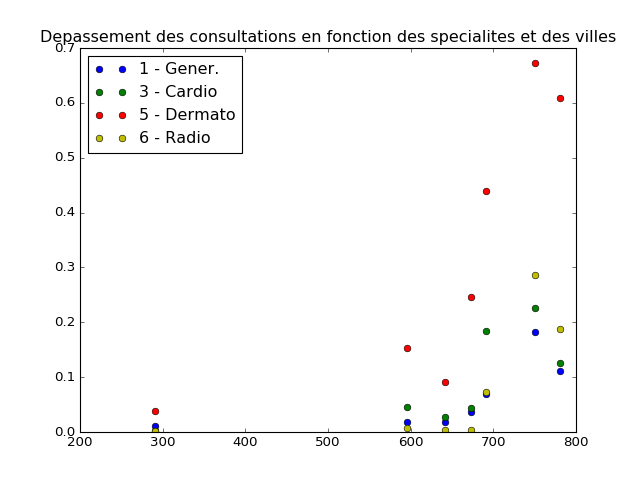

In [249]:
# on va ploter ca
spe1=tab_pourc[tab_pourc['speciality']==1]
spe3=tab_pourc[tab_pourc['speciality']==3]
spe5=tab_pourc[tab_pourc['speciality']==5]
spe6=tab_pourc[tab_pourc['speciality']==6]

pyplot.plot(spe1['departement'], spe1['depassement'], 'o', color='b', label='1 - Gener.')
pyplot.plot(spe3['departement'], spe3['depassement'], 'o', color='g', label='3 - Cardio')
pyplot.plot(spe5['departement'], spe5['depassement'], 'o', color='r', label='5 - Dermato')
pyplot.plot(spe6['departement'], spe6['depassement'], 'o', color='y', label='6 - Radio')
pyplot.legend(loc='upper left')
pyplot.title('Depassement des consultations en fonction des specialites et des villes')

In [413]:
# Maintenant que l'on a les depassements, on va pouvoir les ponderer en fonction de la densite de chaque departement
nb_med = pd.read_csv('rpps-medecins.csv', delimiter=';')
nb_med.head()
print 'NB_MED = \n', nb_med

med = nb_med
med.columns = ['zone', '29', '59', '64', '67', '69', '75', '78']
#med.head()

print 'MED = \n', med
#print med['29'][2]#/med['29'][4])


NB_MED = 
                          ZONE INSCRIPT  29 - Finistere  59 - Nord  \
0   Cardiologie et maladies vasculaires              86        268   
1          Dermatologie et venereologie              52        135   
2  Radiodiagnostic et imagerie medicale              94        427   
3                     Medecine generale            1522       4328   
4                             Habitants          903293    2595536   

   64 - Pyrenees-Atlantiques  67 - Bas-Rhin  69 - Rhone  75 - Paris  \
0                         84            148         231         605   
1                         49             80         141         504   
2                        107            194         321         792   
3                       1227           1914        3188        5429   
4                     664057        1109460      442851     2229621   

   78 - Yvelines  
0            154  
1             94  
2            153  
3           1814  
4        1418484  
MED = 
                     

In [414]:
# On va calculer le ratio medecin par hab.
ratio = med
print '\nRATIO avant  = \n', ratio

ratio['29'][0] = 'TEST'#float(1.0*int(med['29'][0])/(int(med['29'][4])))
ratio['29'][1] = float(1.0*int(med['29'][1])/(int(med['29'][4])))
ratio['29'][2] = float(1.0*int(med['29'][2])/(int(med['29'][4])))
ratio['29'][3] = float(1.0*int(med['29'][3])/(int(med['29'][4])))

ratio['59'][0] = 'TEST'#float(1.0*int(med['29'][0])/(int(med['29'][4])))
ratio['59'][1] = float(1.0*int(med['59'][1])/(int(med['59'][4])))
ratio['59'][2] = float(1.0*int(med['59'][2])/(int(med['59'][4])))
ratio['59'][3] = float(1.0*int(med['59'][3])/(int(med['59'][4])))

ratio['64'][0] = 'TEST'#float(1.0*int(med['29'][0])/(int(med['29'][4])))
ratio['64'][1] = float(1.0*int(med['64'][1])/(int(med['64'][4])))
ratio['64'][2] = float(1.0*int(med['64'][2])/(int(med['64'][4])))
ratio['64'][3] = float(1.0*int(med['64'][3])/(int(med['64'][4])))

ratio['67'][0] = 'TEST'#float(1.0*int(med['29'][0])/(int(med['29'][4])))
ratio['67'][1] = float(1.0*int(med['67'][1])/(int(med['67'][4])))
ratio['67'][2] = float(1.0*int(med['67'][2])/(int(med['67'][4])))
ratio['67'][3] = float(1.0*int(med['67'][3])/(int(med['67'][4])))

ratio['69'][0] = 'TEST'#float(1.0*int(med['29'][0])/(int(med['29'][4])))
ratio['69'][1] = float(1.0*int(med['69'][1])/(int(med['69'][4])))
ratio['69'][2] = float(1.0*int(med['69'][2])/(int(med['69'][4])))
ratio['69'][3] = float(1.0*int(med['69'][3])/(int(med['69'][4])))

ratio['75'][0] = 'TEST'#float(1.0*int(med['29'][0])/(int(med['29'][4])))
ratio['75'][1] = float(1.0*int(med['75'][1])/(int(med['75'][4])))
ratio['75'][2] = float(1.0*int(med['75'][2])/(int(med['75'][4])))
ratio['75'][3] = float(1.0*int(med['75'][3])/(int(med['75'][4])))

ratio['78'][0] = 'TEST'#float(1.0*int(med['78'][0])/(int(med['78'][4])))
ratio['78'][1] = float(1.0*int(med['78'][1])/(int(med['78'][4])))
ratio['78'][2] = float(1.0*int(med['78'][2])/(int(med['78'][4])))
ratio['78'][3] = float(1.0*int(med['78'][3])/(int(med['78'][4])))

ratio['29'][0] = 0.0000952072
ratio['59'][0] = 0.000103254
ratio['64'][0] = 0.000126495
ratio['67'][0] = 0.000133398
ratio['69'][0] = 0.00052162
ratio['75'][0] = 0.000271347
ratio['78'][0] = 0.000108567

print '\nRATIO = \n', ratio



RATIO avant  = 
                                   zone      29       59      64       67  \
0   Cardiologie et maladies vasculaires      86      268      84      148   
1          Dermatologie et venereologie      52      135      49       80   
2  Radiodiagnostic et imagerie medicale      94      427     107      194   
3                     Medecine generale    1522     4328    1227     1914   
4                             Habitants  903293  2595536  664057  1109460   

       69       75       78  
0     231      605      154  
1     141      504       94  
2     321      792      153  
3    3188     5429     1814  
4  442851  2229621  1418484  


/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveat


RATIO = 
                                   zone           29           59  \
0   Cardiologie et maladies vasculaires  9.52072e-05  0.000103254   
1          Dermatologie et venereologie  5.75671e-05  5.20124e-05   
2  Radiodiagnostic et imagerie medicale  0.000104064  0.000164513   
3                     Medecine generale   0.00168495   0.00166748   
4                             Habitants       903293      2595536   

            64           67           69           75           78  
0  0.000126495  0.000133398   0.00052162  0.000271347  0.000108567  
1  7.37888e-05  7.21072e-05  0.000318392  0.000226047  6.62679e-05  
2  0.000161131   0.00017486  0.000724849  0.000355217  0.000107862  
3   0.00184773   0.00172516   0.00719881   0.00243494   0.00127883  
4       664057      1109460       442851      2229621      1418484  


/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the ca

zone    Medecine generale
29             0.00168495
59             0.00166748
64             0.00184773
67             0.00172516
69             0.00719881
75             0.00243494
78             0.00127883
Name: 3, dtype: object


<IPython.core.display.Javascript object>


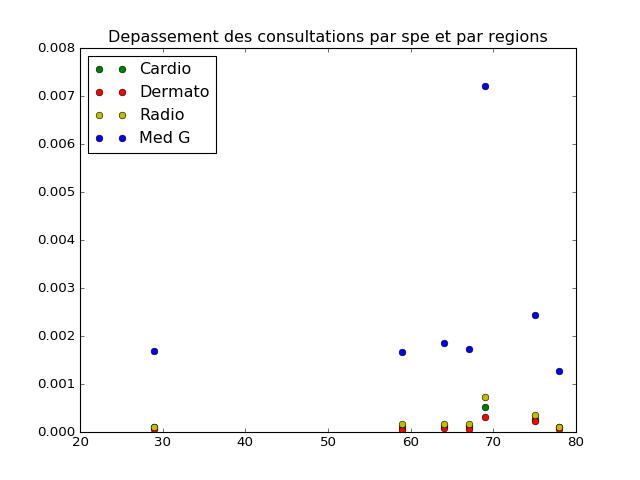

In [430]:
print ratio.ix[3]
dep = ['29', '59', '64', '67', '69', '75', '78']
pyplot.figure()
pyplot.plot(dep, ratio.ix[0][dep], 'o', color='g', label='Cardio')
pyplot.plot(dep, ratio.ix[1][dep], 'o', color='r', label='Dermato')
pyplot.plot(dep, ratio.ix[2][dep], 'o', color='y', label='Radio')
pyplot.plot(dep, ratio.ix[3][dep], 'o', color='b', label='Med G')
pyplot
#pyplot.plot(dep, ratio.ix[4][dep], 'o', color='y', label='6 - Radio')
pyplot.legend(loc='upper left')
pyplot.title('Depassement des consultations par spe et par regions')